# ViT

In [1]:
# Install required libraries
!pip install transformers torchmetrics

# Import necessary libraries
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from transformers import ViTForImageClassification, ViTConfig
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm
from collections import defaultdict

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths to dataset
train_path = '/content/drive/My Drive/grain/images/train'
valid_path = '/content/drive/My Drive/grain/images/val'
test_path = '/content/drive/My Drive/grain/images/test'

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets
train_ds = datasets.ImageFolder(train_path, transform=transform)
valid_ds = datasets.ImageFolder(valid_path, transform=transform)
test_ds = datasets.ImageFolder(test_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=20, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=20, shuffle=False)

# Initialize the ViT model
num_classes = len(train_ds.classes)
config = ViTConfig.from_pretrained('google/vit-base-patch16-224', num_labels=num_classes)
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', config=config, ignore_mismatched_sizes=True)

# Replace classification head to match number of classes
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# Training function
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for inputs, labels in tqdm(loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)
    return avg_loss, accuracy

# Per-class evaluation function
def evaluate_per_class(model, loader, criterion, device):
    model.eval()
    correct_predictions = defaultdict(int)
    total_samples = defaultdict(int)

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating per class"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits
            _, predicted = torch.max(outputs, 1)

            for pred, true_label in zip(predicted, labels):
                if pred == true_label:
                    correct_predictions[true_label.item()] += 1
                total_samples[true_label.item()] += 1

    accuracy_per_class = {class_idx: correct_predictions[class_idx] / total_samples[class_idx] for class_idx in correct_predictions}
    return accuracy_per_class

# Training loop with early stopping
num_epochs = 50
early_stop_patience = 3
best_valid_loss = float('inf')
epochs_since_improvement = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion, device)
    valid_accuracy_per_class = evaluate_per_class(model, valid_loader, criterion, device)

    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement == early_stop_patience:
        print("Early stopping triggered")
        break

    scheduler.step()

# Evaluate on the test set
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")






   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.8 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.7335, Training Accuracy: 0.7694
Validation Loss: 0.4606, Validation Accuracy: 0.8450
Epoch 2/50


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.1940, Training Accuracy: 0.9356
Validation Loss: 0.2490, Validation Accuracy: 0.9150
Epoch 3/50


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.0794, Training Accuracy: 0.9744
Validation Loss: 0.2363, Validation Accuracy: 0.9225
Epoch 4/50


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.0591, Training Accuracy: 0.9825
Validation Loss: 0.2032, Validation Accuracy: 0.9300
Epoch 5/50


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.0133, Training Accuracy: 0.9981
Validation Loss: 0.1723, Validation Accuracy: 0.9525
Epoch 6/50


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.0149, Training Accuracy: 0.9956
Validation Loss: 0.1685, Validation Accuracy: 0.9500
Epoch 7/50


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.0097, Training Accuracy: 0.9975
Validation Loss: 0.1593, Validation Accuracy: 0.9525
Epoch 8/50


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.0026, Training Accuracy: 1.0000
Validation Loss: 0.1511, Validation Accuracy: 0.9525
Epoch 9/50


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.0020, Training Accuracy: 1.0000
Validation Loss: 0.1514, Validation Accuracy: 0.9525
Epoch 10/50


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.0017, Training Accuracy: 1.0000
Validation Loss: 0.1548, Validation Accuracy: 0.9550
Epoch 11/50


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating per class:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.0015, Training Accuracy: 1.0000
Validation Loss: 0.1549, Validation Accuracy: 0.9550
Early stopping triggered


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Test Loss: 0.1549, Test Accuracy: 0.9550


In [2]:
torch.save(model.state_dict(), '/content/drive/My Drive/grain/models/my_vit_model.pth')

# **Performance Evaluation**

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Test Loss: 0.1549
Test Accuracy: 0.9550
 Precision: 0.9555
 Recall: 0.9550
 F1 Score: 0.9546


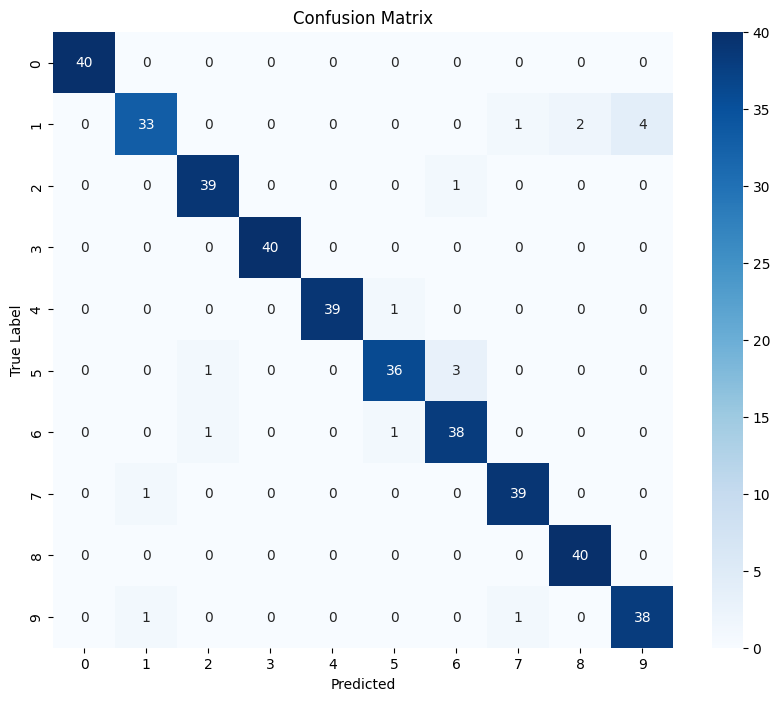

In [3]:
import torch
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)

    # Compute metrics
    precision = precision_score(all_true_labels, all_predictions, average='macro')
    recall = recall_score(all_true_labels, all_predictions, average='macro')
    f1 = f1_score(all_true_labels, all_predictions, average='macro')

    # Compute confusion matrix
    conf_mat = confusion_matrix(all_true_labels, all_predictions)

    return avg_loss, accuracy, precision, recall, f1, conf_mat

# Evaluate on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1, conf_mat = evaluate(model, test_loader, criterion, device)

# Print the metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f" Precision: {test_precision:.4f}")
print(f" Recall: {test_recall:.4f}")
print(f" F1 Score: {test_f1:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Class 0 - Precision: 1.0000, Recall: 1.0000, F1: 1.0000, Accuracy: 1.0000


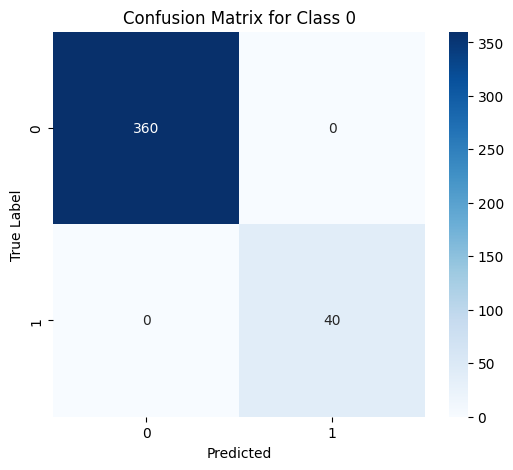

Class 1 - Precision: 0.9429, Recall: 0.8250, F1: 0.8800, Accuracy: 0.9775


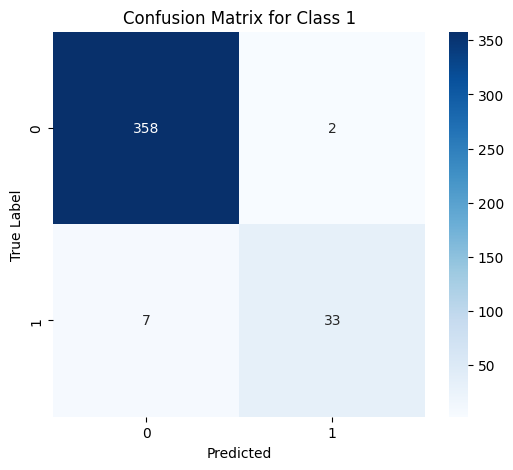

Class 2 - Precision: 0.9512, Recall: 0.9750, F1: 0.9630, Accuracy: 0.9925


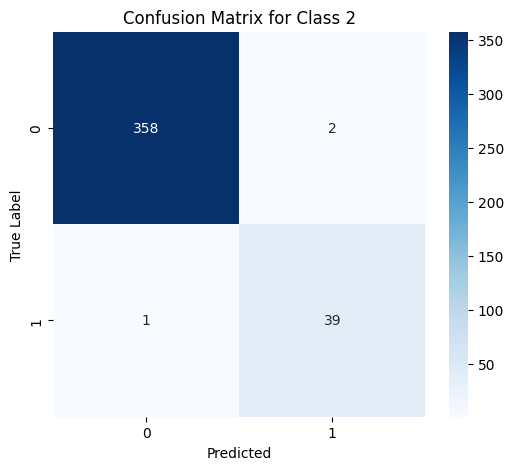

Class 3 - Precision: 1.0000, Recall: 1.0000, F1: 1.0000, Accuracy: 1.0000


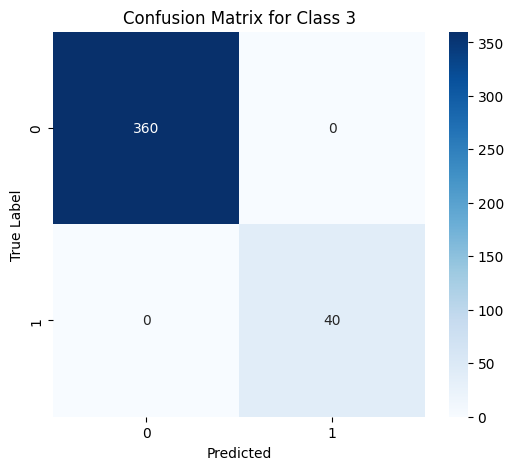

Class 4 - Precision: 1.0000, Recall: 0.9750, F1: 0.9873, Accuracy: 0.9975


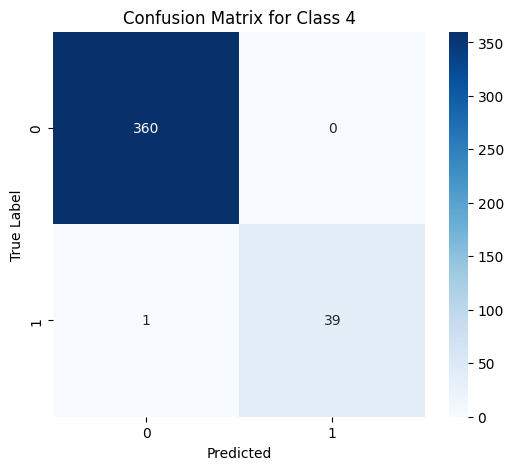

In [4]:
import torch
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluation function
def evaluate_per_class(model, loader, criterion, device, num_classes):
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs).logits
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    metrics_per_class = {}
    conf_matrices = {}

    for class_index in range(num_classes):
        # Treat each class as binary (class vs. not class)
        binary_true = (np.array(all_true_labels) == class_index).astype(int)
        binary_pred = (np.array(all_predictions) == class_index).astype(int)

        # Calculate metrics
        precision = precision_score(binary_true, binary_pred)
        recall = recall_score(binary_true, binary_pred)
        f1 = f1_score(binary_true, binary_pred)
        accuracy = accuracy_score(binary_true, binary_pred)

        # Compute confusion matrix
        conf_mat = confusion_matrix(binary_true, binary_pred)

        metrics_per_class[class_index] = {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}
        conf_matrices[class_index] = conf_mat

    return metrics_per_class, conf_matrices

# Number of classes
num_classes = 5

# Evaluate on the test set
metrics_per_class, conf_matrices = evaluate_per_class(model, test_loader, criterion, device, num_classes)

# Print metrics and plot confusion matrices
for class_index in range(num_classes):
    metrics = metrics_per_class[class_index]
    print(f"Class {class_index} - Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}, Accuracy: {metrics['accuracy']:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrices[class_index], annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Class {class_index}')
    plt.show()


# **ROC-AUC**

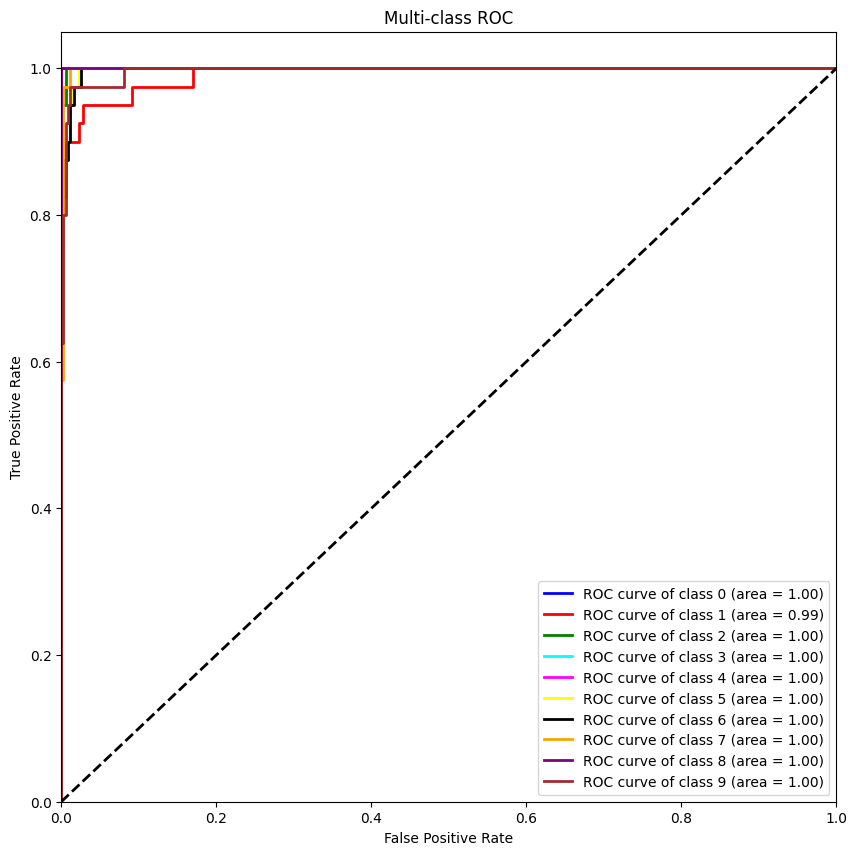

In [5]:
from itertools import cycle # Import the cycle function from itertools

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def evaluate_and_get_predictions(model, loader, device, n_classes):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).logits
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            all_preds.append(probabilities.cpu().numpy())
            all_true.append(labels.cpu().numpy())

    # Binarize the labels
    all_true_bin = label_binarize(np.concatenate(all_true), classes=range(n_classes))
    return all_true_bin, np.concatenate(all_preds)

# Get the test data predictions and true labels
n_classes = len(train_ds.classes)
y_test_bin, y_score = evaluate_and_get_predictions(model, test_loader, device, n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown'])
plt.figure(figsize=(10, 10))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()
